In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc,precision_recall_curve,roc_curve,confusion_matrix
import os,sys
import pickle
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import random
import seaborn as sns
np.random.seed(10)
random.seed(10)


## Functions for loading data

In [27]:
def load_training_and_validataion_dataset(path_to_partitions,train_splits):
    import random
    ## Training
    # training_partions = random.sample(range(10),train_splits)
    training_partions = [9, 0, 6, 3, 4, 8, 1, 7]

    ## Validation
    validation_partions = [i for i in range(10) if i not in training_partions]
    partitions = []
    for file in os.listdir(path_to_partitions):
        path_to_file = os.path.join(path_to_partitions,file)
        data = pd.read_csv(path_to_file,sep="\t",names=["peptide","label","HLA_allele"])
        partitions.append(data)
    training_df = pd.concat([partitions[i] for i in training_partions])
    validation_df = pd.concat([partitions[i] for i in validation_partions])
    return training_df, validation_df,training_partions,validation_partions

def retrieve_information_from_df(data_split,entire_df):
    immunogenicity = []
    response = []
    tested_subjects = []
    positive_subjects = []
    binding_scores = []
    for i,row in data_split.iterrows():
        peptide, HLA = row["peptide"], row['HLA_allele']
        original_entry = entire_df[(entire_df['peptide']==peptide) & (entire_df['HLA_allele'] == HLA)]
        assert len(original_entry) == 1
        immunogenicity.append(float(original_entry['immunogenicity']))
        response.append(original_entry['Response'].values[0])
        tested_subjects.append(int(original_entry['tested_subjects']))
        positive_subjects.append(int(original_entry['positive_subjects']))
        binding_scores.append(float(original_entry['binding_score']))
    data_split['immunogenicity'] = immunogenicity
    data_split['response'] = response
    data_split['test'] = tested_subjects
    data_split['positive_subjects'] = positive_subjects
    data_split['binding_score'] = binding_scores
    return data_split  


def encode_peptide_aaindex(aa_seq,aaindex_PCA,row):
    aa_seq = list(aa_seq.upper())
    encoded_aa_seq = []
    PCs = aaindex_PCA.shape[1]
    for aa in aa_seq:
        if aa == "X" or aa == "-":
            encoded_aa_seq.append(np.array([0 for x in range(PCs)]))
        else:
            try:
                encoded_aa_seq.append(aaindex_PCA.loc[aa].to_numpy())
            except KeyError:
                print(row)
                sys.exit(1)
    return np.array(encoded_aa_seq)

def encode_dataset(df,aaindex_PCA,HLA_dict,peptide_len,padding="right"):
    encoded_peptides = []
    encoded_labels = []
    encoded_hlas = []
    encoded_binding_scores = []
    for i,row in df.iterrows():
        peptide = row["peptide"]
        HLA = HLA_dict[row["HLA_allele"].replace(":","")]
        encoded_peptide = encode_peptide_aaindex(peptide,aaindex_PCA,row)
        binding_score = row['binding_score']


        # Adding padding
        if len(encoded_peptide) < peptide_len:
            n_added = peptide_len-len(encoded_peptide)
            if padding == "right":
                encoded_peptide = np.pad(encoded_peptide, ((0, 1), (0, 0)), 'constant')
            elif padding == "left":
                encoded_peptide = np.pad(encoded_peptide, ((1, 0), (0, 0)), 'constant')
            elif padding == "random":
                top_pad = random.choice([0,1])
                bot_pad = 1-top_pad
                encoded_peptide = np.pad(encoded_peptide, ((top_pad, bot_pad), (0, 0)), 'constant')


        encoded_HLA = encode_peptide_aaindex(HLA,aaindex_PCA,row)
        encoded_label = min(1,row["positive_subjects"])
        encoded_peptides.append(encoded_peptide)
        encoded_hlas.append(encoded_HLA)
        encoded_labels.append(encoded_label)
        encoded_binding_scores.append(binding_score)
    
    encoded_peptides = np.array(encoded_peptides).astype('float32')
    encoded_hlas = np.array(encoded_hlas).astype('float32')
    encoded_labels = np.array(encoded_labels).astype('float32')
    encoded_binding_scores = np.array(encoded_binding_scores).astype('float32')
    return encoded_peptides, encoded_hlas, encoded_binding_scores, encoded_labels


## Loading the data

In [28]:
# Loading the databases
aaindex_PCA = pd.read_csv('../data/PCA_repr_aa.csv',index_col=0)
hla_database = pd.read_csv('../data/formatted_hla2paratope_MHC_pseudo.dat', sep=' ',index_col=0)
hla_dic = hla_database.to_dict("dict")["pseudo"]

# Load dataset
# entire_df = pd.read_csv('../data/filtered_data_IEDB_4_tested_len_9_10_full_HLA_IFNg_assay.csv')
entire_df = pd.read_csv("../data/filtered_data_IEDB_4_tested_len_9_10_full_HLA_Multi_assay_w_binding.csv")
# entire_df = pd.read_csv('../data/deep_immuno_2.csv')


# Allocating the partitions of the trainign and validation data
training_df, validation_df, training_partions,validation_partions = load_training_and_validataion_dataset(path_to_partitions="../data/multi_assay_parts",train_splits=8)


# Creating the training dataframe (With correct information such as tested and positive subjects aswell as label)
training_df_entire = retrieve_information_from_df(training_df,entire_df)
# Shuffling the dataframe
training_df_entire = training_df_entire.sample(frac=1, random_state=1).reset_index(drop=True)

# Creating the validation dataframe (With correct information such as tested and positive subjects aswell as label)
validation_df_entire = retrieve_information_from_df(validation_df,entire_df)
# Shuffling the dataframe
validation_df_entire = validation_df_entire.sample(frac=1, random_state=1).reset_index(drop=True)

print("##Encoding Training data")
train_peptides_encoded,train_HLA_encoded,train_binding_scores_encoded,train_label_encoded = encode_dataset(training_df_entire,aaindex_PCA,hla_dic,peptide_len=10,padding="right")
print("##Encoding Validation data")
val_peptides_encoded,val_HLA_encoded,val_binding_scores_encoded ,val_label_encoded = encode_dataset(validation_df_entire,aaindex_PCA,hla_dic,peptide_len=10,padding="right")

peptide_train = train_peptides_encoded.reshape(-1,1,10,12)
HLA_train = train_HLA_encoded.reshape(-1,1,34,12)
binding_train = train_binding_scores_encoded
label_train = train_label_encoded

peptide_val = val_peptides_encoded.reshape(-1,1,10,12)
HLA_val = val_HLA_encoded.reshape(-1,1,34,12) # 46 aligned representataion and 34 if not aligned
binding_val = val_binding_scores_encoded
label_val = val_label_encoded


##Encoding Training data
##Encoding Validation data


## Definning the model

In [29]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d

In [30]:
def compute_conv_dim(dim_size,kernel_size,padding,stride):
    return int((dim_size - kernel_size + 2 * padding) / stride + 1)
compute_conv_dim(34,2,0,1)

33

In [31]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
          nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
          if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
          nn.init.constant_(m.weight.data, 1)
          nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
          nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
          if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
          

In [32]:
# hyperameters of the model
n = peptide_train.shape[0]
peptide_input_channels = peptide_train.shape[1]
peptide_input_height = peptide_train.shape[2]
peptide_input_width = peptide_train.shape[3]

hla_input_channels = HLA_train.shape[1]
hla_input_height = HLA_train.shape[2]
hla_input_width = HLA_train.shape[3]

overall_dim = np.prod(peptide_train.shape[1:]) + np.prod(HLA_train.shape[1:])


# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # Denselayer
        self.L_in = Linear(in_features=529, # 528 if binding_score None, else 529
                            out_features= 1058)

        self.batchnorm1 = nn.BatchNorm1d(1058)
        self.drop_out1 = nn.Dropout(p=0.4)

        self.L_2 = Linear(in_features = 1058,
                            out_features = 750)

        self.batchnorm2 = nn.BatchNorm1d(750)
        self.drop_out2 = nn.Dropout(p=0.4)

        self.L_out = Linear(in_features = 750,
                            out_features = 2)
    
    def forward(self, peptide, HLA, binding_score=None): # x.size() = [batch, channel, height, width]

        # Encoding the peptide
        # peptide = self.conv1_peptide(peptide)
        # peptide = self.BatchNorm_conv1_peptides(peptide)
        # peptide = relu(peptide)
        # peptide = self.conv2_peptide(peptide)
        # peptide = self.BatchNorm_conv2_peptides(peptide)
        # peptide = relu(peptide)
        # peptide = self.maxpool1_peptide(peptide)
        peptide = torch.flatten(peptide,start_dim=1)

        # Encoding the HLA
        # HLA = self.conv1_HLA(HLA)
        # HLA = self.BatchNorm_conv1_HLA(HLA)
        # HLA = relu(HLA)
        # HLA = self.maxpool1_HLA(HLA)
        # HLA = self.conv2_HLA(HLA)
        # HLA = self.BatchNorm_conv2_HLA(HLA)
        # HLA = relu(HLA)
        # HLA = self.maxpool2_HLA(HLA)
        HLA = torch.flatten(HLA,start_dim=1)

        if binding_score is None:
            combined_input = torch.cat((peptide, HLA), 1)
      
        else:
            combined_input = torch.cat((peptide, HLA,binding_score), 1)

        x = self.L_in(combined_input)
        x = relu(x)
        x = self.batchnorm1(x)
        x = self.drop_out1(x)
    
        x = self.L_2(x)
        x = relu(x)
        x = self.batchnorm2(x)
        x = self.drop_out2(x)
        x = self.L_out(x)
        x = relu(x)
        return softmax(x, dim=1)

net = Net()
net.apply(initialize_weights)
print(net)

Net(
  (L_in): Linear(in_features=529, out_features=1058, bias=True)
  (batchnorm1): BatchNorm1d(1058, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_out1): Dropout(p=0.4, inplace=False)
  (L_2): Linear(in_features=1058, out_features=750, bias=True)
  (batchnorm2): BatchNorm1d(750, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_out2): Dropout(p=0.4, inplace=False)
  (L_out): Linear(in_features=750, out_features=2, bias=True)
)


Testing flow through network

In [33]:
peptide_random = np.random.normal(0,1, (10, 1, 10, 12)).astype('float32')
peptide_random = Variable(torch.from_numpy(peptide_random))
HLA_random = np.random.normal(0,1, (10, 1, 34, 12)).astype('float32')
HLA_random = Variable(torch.from_numpy(HLA_random))
binding_random = np.random.normal(0,1, (10, 1)).astype('float32')
binding_random = Variable(torch.from_numpy(binding_random))

output = net(peptide_random,HLA_random)
output

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x528 and 529x1058)

## Creating testing and validataion datasets

In [34]:
batch_size = 100
peptide_train_loader = list(DataLoader(peptide_train,batch_size=batch_size))
HLA_train_loader = list(DataLoader(HLA_train,batch_size=batch_size))
label_train_loader = list(DataLoader(label_train,batch_size=batch_size))
binding_score_train_loader = list(DataLoader(binding_train,batch_size=batch_size))


peptide_val_loader = list(DataLoader(peptide_val,batch_size=batch_size))
HLA_val_loader = list(DataLoader(HLA_val,batch_size=batch_size))
label_val_loader = list(DataLoader(label_val,batch_size=batch_size))
binding_score_val_loader = list(DataLoader(binding_val,batch_size=batch_size))

## Training and evaluating the model

In [35]:
import torch.optim as optim
from sklearn.metrics import accuracy_score,recall_score,f1_score
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001,weight_decay=1e-4)

In [36]:
epochs = 100
train_accuracies = []
val_accuracies = []
losses = []
all_val_targets_pr_epoch = []
all_val_predictions_pr_epoch = []
all_val_probabilities_pr_epoch = []
for epoch in range(epochs):
    net.train()
    current_loss = 0
    for train_batch_index in range(len((peptide_train_loader))):
        train_peptides = peptide_train_loader[train_batch_index]
        train_HLA = HLA_train_loader[train_batch_index]
        train_labels = label_train_loader[train_batch_index].long().reshape(-1)
        train_binding_scores = binding_score_train_loader[train_batch_index].reshape(len(train_peptides),1)
        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = net(train_peptides,train_HLA, train_binding_scores) # add binding scores here if you want them
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()

    # print(epoch, current_loss/batch_size)
    losses.append(current_loss/len((peptide_train_loader)))

    net.eval()
    with torch.no_grad():
        all_train_targets = []
        all_predicted_train_labels = []
        for i in range(len((peptide_train_loader))):
            train_peptides = peptide_train_loader[i]
            train_HLA = HLA_train_loader[i]
            train_labels = label_train_loader[i].long().reshape(-1)
            train_binding_scores = binding_score_train_loader[i].reshape(len(train_peptides),1)
            outputs = net(train_peptides,train_HLA, train_binding_scores) # add binding scores here too
            _,predicted_labels =  torch.max(outputs, 1)

            all_predicted_train_labels += predicted_labels.numpy().tolist()
            all_train_targets += train_labels.numpy().tolist()
        
        all_val_targets = []
        all_predicted_val_labels = []
        all_probabilities_val = []
        for j in range(len((peptide_val_loader))):
            val_peptides = peptide_val_loader[j]
            val_HLA = HLA_val_loader[j]
            val_labels = label_val_loader[j].long().reshape(-1)
            val_binding_scores = binding_score_val_loader[j].reshape(len(val_peptides),1)
            outputs = net(val_peptides,val_HLA, val_binding_scores)   # and also add binding_scores here
            probability,predicted_labels =  torch.max(outputs, 1)
            all_predicted_val_labels += predicted_labels.numpy().tolist()
            all_val_targets += val_labels.numpy().tolist()
            all_probabilities_val += probability.numpy().tolist()

    # Calculating the accuracies
    train_accuracies.append(accuracy_score(all_train_targets,all_predicted_train_labels))
    val_accuracies.append(accuracy_score(all_val_targets,all_predicted_val_labels))
    print(train_accuracies)
    print(val_accuracies)
    # Saving the predicitons for further validation
    all_val_targets_pr_epoch.append(all_val_targets)
    all_val_predictions_pr_epoch.append(all_predicted_val_labels)
    all_val_probabilities_pr_epoch.append(all_probabilities_val)
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (epoch+1, losses[-1], train_accuracies[-1], val_accuracies[-1]))
    


[0.6838175620840773]
[0.6737400530503979]
Epoch  1 : Train Loss 0.623106 , Train acc 0.683818, Valid acc 0.673740
[0.6838175620840773, 0.6883622788508359]
[0.6737400530503979, 0.6750663129973474]
[0.6838175620840773, 0.6883622788508359, 0.6984255802629443]
[0.6737400530503979, 0.6750663129973474, 0.6843501326259946]
[0.6838175620840773, 0.6883622788508359, 0.6984255802629443, 0.7093004382405453]
[0.6737400530503979, 0.6750663129973474, 0.6843501326259946, 0.6856763925729443]
[0.6838175620840773, 0.6883622788508359, 0.6984255802629443, 0.7093004382405453, 0.7284531731861711]
[0.6737400530503979, 0.6750663129973474, 0.6843501326259946, 0.6856763925729443, 0.696949602122016]
[0.6838175620840773, 0.6883622788508359, 0.6984255802629443, 0.7093004382405453, 0.7284531731861711, 0.7365687388410972]
[0.6737400530503979, 0.6750663129973474, 0.6843501326259946, 0.6856763925729443, 0.696949602122016, 0.6850132625994695]
[0.6838175620840773, 0.6883622788508359, 0.6984255802629443, 0.709300438240545

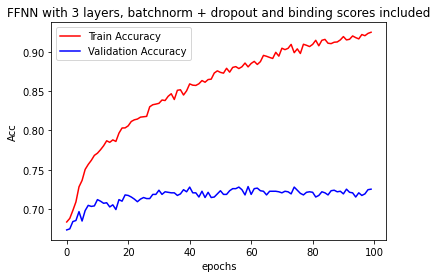

In [37]:
epoch = np.arange(len(train_accuracies))
plt.figure()
plt.plot(epoch, train_accuracies, 'r', epoch, val_accuracies, 'b')
plt.title("FFNN with 3 layers, batchnorm + dropout and binding scores included")
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.xlabel('epochs'), plt.ylabel('Acc')
plt.savefig("../plots/FFNN_3_layers_bigthensmall_btchnrm_drpt_bndscr.png", dpi = 400, transparent = False)

In [12]:
val_predictions = np.array(all_val_predictions_pr_epoch)
val_labels = np.array(all_val_targets_pr_epoch)
val_probabilities = np.array(all_val_probabilities_pr_epoch)

EPOCH: 91 Recall: 0.6944801026957638 accuracy: 0.7380636604774535 f1-score: 0.7325660121868652


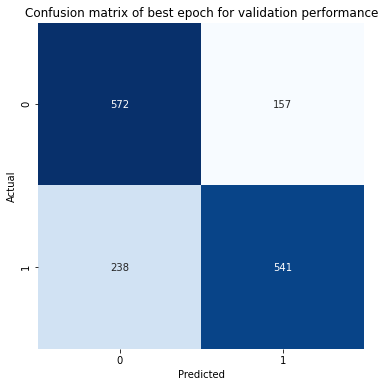

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,recall_score

best_epoch_model = np.argmax(val_accuracies)

# for epoch in range(len(val_predictions)):
fig = plt.figure(figsize=(10,6))
accuracy = accuracy_score(val_labels[best_epoch_model],val_predictions[best_epoch_model])
recall = recall_score(val_labels[best_epoch_model],val_predictions[best_epoch_model])
f1 = f1_score(val_labels[best_epoch_model],val_predictions[best_epoch_model])

print(f"EPOCH: {best_epoch_model} Recall: {recall} accuracy: {accuracy} f1-score: {f1}")
plt.title("Confusion matrix of best epoch for validation performance")
conf_mat = confusion_matrix(val_labels[best_epoch_model],val_predictions[best_epoch_model])
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [14]:
labels_best_epoch = val_labels[best_epoch_model]
predictions_best_epoch = val_predictions[best_epoch_model]
probabilities_best_epoch = val_probabilities[best_epoch_model]
true_predictions = [x==y for x,y in zip(labels_best_epoch,predictions_best_epoch)]
dataframe = pd.DataFrame()
dataframe["Probs"] = probabilities_best_epoch
dataframe["Predictions"] = predictions_best_epoch
dataframe["Labels"] = labels_best_epoch
dataframe["True"] = true_predictions

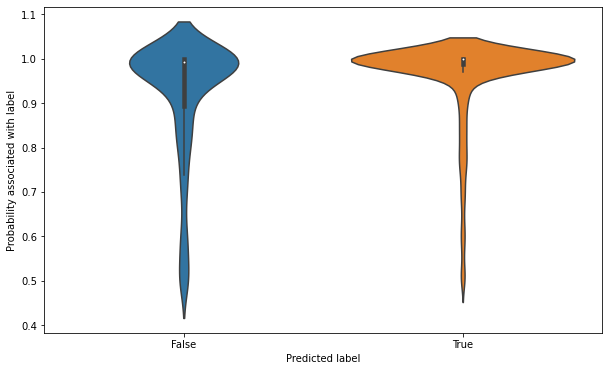

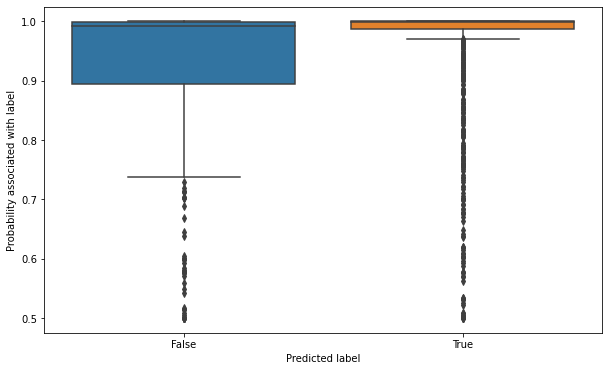

In [15]:
plt.figure(figsize=(10,6))
ax = sns.violinplot(x="True", y="Probs", data=dataframe)
plt.xlabel("Predicted label")
plt.ylabel("Probability associated with label")
plt.show()

plt.figure(figsize=(10,6))
ax = sns.boxplot(x="True", y="Probs", data=dataframe)
plt.xlabel("Predicted label")
plt.ylabel("Probability associated with label")
plt.show()